# DOTA - Statistics

In [45]:
#Data Crawling
import dota2api
from time import sleep
import json

#Data Processing
import pandas as pd
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Exercise 1: Data Crawling
### Initialize Dota2API

In [ ]:
api = dota2api.Initialise("1B9E8D8FCFE1FA1BFC6817C7DFBDFB75")

### Get Data (Crawler)
#### Check 500
Check whether the API call was refused by server.

In [21]:
def check500(accountid):
    mlist = []
    flag = 0
    num_matches = 0
    num_matches_new = 1
    print("test")
    while num_matches < num_matches_new:
        if len(mlist) == 0:
            try:
                hist = api.get_match_history(account_id=accountid)
            except:
                sleep(30)
                print('sleepy')
        else:
            try:
                hist = api.get_match_history(account_id=accountid, start_at_match_id=mlist[-1], min_players = 10)
            except:
                sleep(30)
                print('sleep')
        sleep(2)
        if hist is not None:
            hist_obj = json.loads(hist.json)

            for i in hist_obj['matches']:
                mlist.append(i['match_id'])
        num_matches = num_matches_new
        num_matches_new = len(list(set(mlist)))
        print("check 500:")
        print(len(list(set(mlist))))
        if len(mlist) > 500:
            flag = 1
            break
    return {'flag':flag, 'mlist':mlist}


#### Crawl history
Get all the matches from the history.

In [ ]:
def crawl_history(accountid, length):
    matchlist = []
    while len(set(matchlist)) < length:
        if len(matchlist) == 0:
            try:
                hist = api.get_match_history(account_id=accountid, min_players = 10)
            except:
                sleep(30)
                print('sleepy')
                crawl_history(accountid)
        else:
            try:
                hist = api.get_match_history(account_id=accountid, start_at_match_id=matchlist[-1], min_players = 10)
            except:
                sleep(30)
                print('sleep')
                crawl_history(accountid)
        sleep(2)

        hist_obj = json.loads(hist.json)

        for i in hist_obj['matches']:
            matchlist.append(i['match_id'])
        print(len(matchlist))
    return matchlist

#### Crawl players
Get more players from the match history

In [ ]:
def crawl_players(x, playerlist=None):
    if playerlist is None:
        playerlist = []
    matches_to_crawl = []
    sleep(5)
    print(x)
    try:
        match = api.get_match_details(match_id=x)
        sleep(2)
        print('gogo')
        match_obj = json.loads(match.json)
        for j in match_obj['players']:
            print("c_p: ")
            print(len(playerlist))
            if len(playerlist) > 101:
                break
            if j['account_id'] not in playerlist:
                print(j['account_id'])
                check = check500(j['account_id'])
                if check['flag'] == 1:
                    playerlist.append(j['account_id'])
                    matches_to_crawl = check['mlist']

        file = open("matches.json", "a")
        file.write(match.json)
        file.write("\n")
        file.close()
    except:
        print('w8')
        sleep(30)
    playerlist = set(playerlist)
    print(len(playerlist))

    return {'matches': matches_to_crawl, 'players': playerlist}

#### Crawl matches
Crawl a single match.

In [ ]:
def crawl_matches(x):
    try:
        match = api.get_match_details(match_id=x)
        print('gogo')
        file = open("matches.json", "a")
        file.write(match.json)
        file.close()
        sleep(2)

    except:
        print('w8')
        sleep(5)
        crawl_matches(x)

### Get Data (main)
Main file which uses the above functions. Acc acts as a starting point for getting random players.

In [ ]:
acc = 105555155

matchlist = crawl_history(acc, 500)

print(len(set(matchlist)))

matchlist = list(set(matchlist))
matchlist.sort(reverse=True)

print('first hist')

matches_to_crawl = []

playerlist = [4294967295, acc]
for i in matchlist:
    data = crawl_players(i, playerlist)
    playerlist.extend(data['players'])
    playerlist = list(set(playerlist))
    matches_to_crawl.extend(data['matches'])
    matches_to_crawl = list(set(matches_to_crawl))
    print(len(matches_to_crawl))


list(set(matches_to_crawl))
matches_to_crawl.sort()

for i in matches_to_crawl:
    crawl_matches(i)

### Convert to Data Frame
Before persisting the data, we convert them to a pandas dataframe for easier access and saving. Each row in the data frame represents 1 player in 1 match. We have decided to use only one table.

In [15]:
pd.set_option('display.max_columns', 70)

In [128]:
import json

data = open('../crawler_erik/matches_erik.json', 'r').readlines()

data0 = json.loads(data[0])
df = pd.DataFrame(columns=pd.DataFrame.from_dict(data0, orient='index').T.columns)

for i, line in enumerate(data):
    data_json = json.loads(line)
    data_df = pd.DataFrame.from_dict(data_json, orient='index').T
    df = df.append(data_df, ignore_index=True)
    
#extract player info
playersTable = df.players.apply(pd.Series)
columnNames = playersTable[0].apply(pd.Series).columns
playersDF = pd.DataFrame(columns=columnNames)
for col in playersTable.columns:
    colDF = playersTable[col].apply(pd.Series)
    playersDF = playersDF.append(colDF)

#take the 100 players which occur most often
playersDF = playersDF.dropna(subset=['account_id'])
playersDF.account_id = playersDF.account_id.astype(int)
top100ids = playersDF.groupby('account_id').size().sort_values().tail(100)
playersDF = playersDF[playersDF.account_id.isin(np.asarray(top100ids.index))]
    
#write in 1 table
data_df = playersDF.join(df)
data_df.account_id = data_df.account_id.astype(int)
data_df = data_df.drop('players', 1) #unpacked in table, currently the index = line in the json file

### Profiling

As the conversion to the data frame took some time, we did some profiling for the lines 15-29. The two for-loops took a particularly long time to execute. Their results were however correct and since we didn't need to run the code multiple times, we decided not to optimize this part. 

In [19]:
%time playersTable = df.players.apply(pd.Series)

CPU times: user 31 s, sys: 1min 18s, total: 1min 49s
Wall time: 2min 6s


In [20]:
columnNames = playersTable[0].apply(pd.Series).columns
playersDF = pd.DataFrame(columns=columnNames)

This took a long time to execute (around 15 min), output got lost in the merge process:

In [ ]:
%%time 

for col in playersTable.columns:
    print(col)
    colDF = playersTable[col].apply(pd.Series)
    playersDF = playersDF.append(colDF)

In [23]:
playersDF.shape

(441230, 35)

In [26]:
%time playersDF = playersDF.dropna(subset=['account_id'])

CPU times: user 654 ms, sys: 1.53 s, total: 2.18 s
Wall time: 2.53 s


In [29]:
%time playersDF.account_id = playersDF.account_id.astype(int)

CPU times: user 4.37 s, sys: 22.1 s, total: 26.4 s
Wall time: 33.7 s


In [30]:
%time top100ids = playersDF.groupby('account_id').size().sort_values().tail(100)

CPU times: user 92.4 ms, sys: 61.5 ms, total: 154 ms
Wall time: 183 ms


In [32]:
%time playersDF = playersDF[playersDF.account_id.isin(np.asarray(top100ids.index))]

CPU times: user 597 ms, sys: 1.54 s, total: 2.14 s
Wall time: 2.82 s


In [33]:
%time data_df = playersDF.join(df)

CPU times: user 702 ms, sys: 776 ms, total: 1.48 s
Wall time: 1.79 s


In [34]:
data_df.account_id = data_df.account_id.astype(int)

In [35]:
data_df = data_df.drop('players', 1)

In [40]:
len(data_df)

181751

In [129]:
data_df.head(3)

ability_upgrades  account_id  \
0  [{'level': 1, 'ability': 5439, 'time': 227}, {...   106534628   
0  [{'level': 1, 'ability': 5144, 'time': 204}, {...   105555155   
0  [{'level': 1, 'ability': 5130, 'time': 189}, {...  4294967295   

  additional_units  assists  deaths  denies    gold  gold_per_min  gold_spent  \
0              NaN     12.0     9.0     0.0  1212.0         292.0      8090.0   
0              NaN      7.0    10.0     4.0   665.0         221.0      6275.0   
0              NaN      7.0    10.0    10.0   993.0         349.0      9375.0   

   hero_damage  hero_healing  hero_id   hero_name  item_0    item_0_name  \
0      12003.0           0.0     84.0   Ogre Magi    60.0  Point Booster   
0       5036.0           0.0     32.0        Riki    36.0     Magic Wand   
0      12801.0           0.0     21.0  Windranger    50.0    Phase Boots   

   item_1         item_1_name  item_2   item_2_name  item_3    item_3_name  \
0   180.0        Arcane Boots    36.0    Magic Wand   244.0            NaN   
0    71.0   Poor Man's Shield   181.0  Orb of Venom    63.0   Power Treads   
0    98.0  Orchid Malevolence    36.0    Magic Wand    77.0  Null Talisman   

   item_4     item_4_name  item_5   item_5_name  kills  last_hits  \
0    42.0   Observer Ward     1.0  Blink Dagger    4.0       39.0   
0   174.0  Diffusal Blade     0.0           NaN    3.0       12.0   
0   166.0       Maelstrom     0.0           NaN    4.0      122.0   

   leaver_status   leaver_status_description leaver_status_name  level  \
0            0.0  finished match, no abandon               NONE   15.0   
0            0.0  finished match, no abandon               NONE   12.0   
0            0.0  finished match, no abandon               NONE   16.0   

   player_slot  tower_damage  xp_per_min barracks_status_dire  \
0          0.0           0.0       367.0                   63   
0          1.0           0.0       242.0                   63   
0          3.0         505.0       394.0                   63   

  barracks_status_radiant cluster cluster_name dire_captain dire_score  \
0                       0     138  Europe West          NaN         48   
0                       0     138  Europe West          NaN         48   
0                       0     138  Europe West          NaN         48   

  duration engine first_blood_time flags game_mode game_mode_name  \
0     2094      1               16     1         1       All Pick   
0     2094      1               16     1         1       All Pick   
0     2094      1               16     1         1       All Pick   

  human_players leagueid          lobby_name lobby_type    match_id  \
0            10        0  Public matchmaking          0  2407551209   
0            10        0  Public matchmaking          0  2407551209   
0            10        0  Public matchmaking          0  2407551209   

  match_seq_num negative_votes picks_bans positive_votes radiant_captain  \
0    2106654547              0        NaN              0             NaN   
0    2106654547              0        NaN              0             NaN   
0    2106654547              0        NaN              0             NaN   

  radiant_score radiant_win  start_time tower_status_dire tower_status_radiant  
0            22       False  1464875129              1974                    0  
0            22       False  1464875129              1974                    0  
0            22       False  1464875129              1974                    0

### Persist Data
In order to not make the same API requests every time, we persist the data.

In [41]:
data_df.to_csv("../data/dota_matches_Full.csv", sep = ",")

## Exercise 2: Data Unterstanding
### Get Data

Warning is due to the parsing of the dire and radiant guild names (e.g. can be sometimes parsed as int). The abilities (column 1) also have different length as arrays.
Unnamed 0 - the row in the json data from which the data item was created

In [20]:
data = pd.read_csv("../data/dota_matches_Full.csv", sep = ",")

/Users/Alex/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,43,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
data.head(3)

Unnamed: 0                                   ability_upgrades  account_id  \
0           0  [{'time': 227, 'level': 1, 'ability': 5439}, {...   106534628   
1           0  [{'time': 204, 'level': 1, 'ability': 5144}, {...   105555155   
2           0  [{'time': 271, 'level': 1, 'ability': 5526}, {...   160080225   

  additional_units  assists  deaths  denies    gold  gold_per_min  gold_spent  \
0              NaN     12.0     9.0     0.0  1212.0         292.0      8090.0   
1              NaN      7.0    10.0     4.0   665.0         221.0      6275.0   
2              NaN      3.0     9.0     4.0  1697.0         371.0     11885.0   

   hero_damage  hero_healing  hero_id  hero_name  item_0         item_0_name  \
0      12003.0           0.0     84.0  Ogre Magi    60.0       Point Booster   
1       5036.0           0.0     32.0       Riki    36.0          Magic Wand   
2      12263.0         306.0     98.0  Timbersaw    46.0  Town Portal Scroll   

   item_1        item_1_name  item_2   item_2_name  item_3   item_3_name  \
0   180.0       Arcane Boots    36.0    Magic Wand   244.0           NaN   
1    71.0  Poor Man's Shield   181.0  Orb of Venom    63.0  Power Treads   
2   232.0        Aether Lens   121.0    Bloodstone   265.0           NaN   

   item_4     item_4_name  item_5   item_5_name  kills  last_hits  \
0    42.0   Observer Ward     1.0  Blink Dagger    4.0       39.0   
1   174.0  Diffusal Blade     0.0           NaN    3.0       12.0   
2     0.0             NaN   180.0  Arcane Boots    8.0      121.0   

   leaver_status   leaver_status_description leaver_status_name  level  \
0            0.0  finished match, no abandon               NONE   15.0   
1            0.0  finished match, no abandon               NONE   12.0   
2            0.0  finished match, no abandon               NONE   15.0   

   player_slot  tower_damage  xp_per_min   0  barracks_status_dire  \
0          0.0           0.0       367.0 NaN                    63   
1          1.0           0.0       242.0 NaN                    63   
2          2.0         223.0       365.0 NaN                    63   

   barracks_status_radiant  cluster cluster_name  dire_captain  dire_guild_id  \
0                        0      138  Europe West           NaN            NaN   
1                        0      138  Europe West           NaN            NaN   
2                        0      138  Europe West           NaN            NaN   

   dire_guild_logo dire_guild_name  dire_score  duration  engine  \
0              NaN             NaN          48      2094       1   
1              NaN             NaN          48      2094       1   
2              NaN             NaN          48      2094       1   

   first_blood_time  flags  game_mode game_mode_name  human_players  leagueid  \
0                16      1          1       All Pick             10         0   
1                16      1          1       All Pick             10         0   
2                16      1          1       All Pick             10         0   

           lobby_name  lobby_type    match_id  match_seq_num  negative_votes  \
0  Public matchmaking           0  2407551209     2106654547               0   
1  Public matchmaking           0  2407551209     2106654547               0   
2  Public matchmaking           0  2407551209     2106654547               0   

  picks_bans  positive_votes  radiant_captain  radiant_guild_id  \
0        NaN               0              NaN               NaN   
1        NaN               0              NaN               NaN   
2        NaN               0              NaN               NaN   

   radiant_guild_logo radiant_guild_name  radiant_score radiant_win  \
0                 NaN                NaN             22       False   
1                 NaN                NaN             22       False   
2                 NaN                NaN             22       False   

   start_time  tower_status_dire  tower_status_radiant  
0  1464875129        

Addressing the issues described above:

In [22]:
data = data.rename(columns={'Unnamed: 0':'file_row_number'})
data.dire_guild_name = data.dire_guild_name.astype(str)
data.radiant_guild_name = data.radiant_guild_name.astype(str)
data.head(3)

file_row_number                                   ability_upgrades  \
0                0  [{'time': 227, 'level': 1, 'ability': 5439}, {...   
1                0  [{'time': 204, 'level': 1, 'ability': 5144}, {...   
2                0  [{'time': 271, 'level': 1, 'ability': 5526}, {...   

   account_id additional_units  assists  deaths  denies    gold  gold_per_min  \
0   106534628              NaN     12.0     9.0     0.0  1212.0         292.0   
1   105555155              NaN      7.0    10.0     4.0   665.0         221.0   
2   160080225              NaN      3.0     9.0     4.0  1697.0         371.0   

   gold_spent  hero_damage  hero_healing  hero_id  hero_name  item_0  \
0      8090.0      12003.0           0.0     84.0  Ogre Magi    60.0   
1      6275.0       5036.0           0.0     32.0       Riki    36.0   
2     11885.0      12263.0         306.0     98.0  Timbersaw    46.0   

          item_0_name  item_1        item_1_name  item_2   item_2_name  \
0       Point Booster   180.0       Arcane Boots    36.0    Magic Wand   
1          Magic Wand    71.0  Poor Man's Shield   181.0  Orb of Venom   
2  Town Portal Scroll   232.0        Aether Lens   121.0    Bloodstone   

   item_3   item_3_name  item_4     item_4_name  item_5   item_5_name  kills  \
0   244.0           NaN    42.0   Observer Ward     1.0  Blink Dagger    4.0   
1    63.0  Power Treads   174.0  Diffusal Blade     0.0           NaN    3.0   
2   265.0           NaN     0.0             NaN   180.0  Arcane Boots    8.0   

   last_hits  leaver_status   leaver_status_description leaver_status_name  \
0       39.0            0.0  finished match, no abandon               NONE   
1       12.0            0.0  finished match, no abandon               NONE   
2      121.0            0.0  finished match, no abandon               NONE   

   level  player_slot  tower_damage  xp_per_min   0  barracks_status_dire  \
0   15.0          0.0           0.0       367.0 NaN                    63   
1   12.0          1.0           0.0       242.0 NaN                    63   
2   15.0          2.0         223.0       365.0 NaN                    63   

   barracks_status_radiant  cluster cluster_name  dire_captain  dire_guild_id  \
0                        0      138  Europe West           NaN            NaN   
1                        0      138  Europe West           NaN            NaN   
2                        0      138  Europe West           NaN            NaN   

   dire_guild_logo dire_guild_name  dire_score  duration  engine  \
0              NaN             nan          48      2094       1   
1              NaN             nan          48      2094       1   
2              NaN             nan          48      2094       1   

   first_blood_time  flags  game_mode game_mode_name  human_players  leagueid  \
0                16      1          1       All Pick             10         0   
1                16      1          1       All Pick             10         0   
2                16      1          1       All Pick             10         0   

           lobby_name  lobby_type    match_id  match_seq_num  negative_votes  \
0  Public matchmaking           0  2407551209     2106654547               0   
1  Public matchmaking           0  2407551209     2106654547               0   
2  Public matchmaking           0  2407551209     2106654547               0   

  picks_bans  positive_votes  radiant_captain  radiant_guild_id  \
0        NaN               0              NaN               NaN   
1        NaN               0              NaN               NaN   
2        NaN               0              NaN               NaN   

   radiant_guild_logo radiant_guild_name  radiant_score radiant_win  \
0                 NaN                nan             22       False   
1                 NaN                nan             22       False   
2                 NaN                nan             22       False   

   start_time  tower_status_dire  tower_status_radiant  
0

### Highest Win Rate (a)

Highest win rate for the user with account id 86730329.

In [23]:
df = data
df['team_radiant'] = df.player_slot <= 4 
df['won'] = (df['team_radiant'] == df['radiant_win'])
account_wins = df.groupby(['account_id', 'won']).size().unstack('won').fillna(0)
account_wins['total'] = account_wins[True] + account_wins[False]
account_wins['win_rate'] = account_wins[True] / account_wins['total']
top10 = account_wins.sort_values('win_rate').tail(5)
top10

won         False  True  total  win_rate
account_id                              
246390023     217   285    502  0.567729
37171865      222   294    516  0.569767
78578911      233   315    548  0.574818
130810519     213   288    501  0.574850
86730329      208   293    501  0.584830

### Hero With the Highest Win Rate (b)

Omniknight has the highest win rate in the database:

In [24]:
hero_wins = df.groupby(['hero_name', 'won']).size().unstack('won').fillna(0)
hero_wins['total'] = hero_wins[True] + hero_wins[False]
hero_wins['win_rate'] = hero_wins[True] / hero_wins['total']
top10 = hero_wins.sort_values('win_rate').tail(5)
top10

won         False  True  total  win_rate
hero_name                               
Abaddon       525   681   1206  0.564677
Medusa        512   669   1181  0.566469
Spectre       951  1270   2221  0.571814
Necrophos    1076  1449   2525  0.573861
Omniknight    675  1120   1795  0.623955

### Most Played Hero (c)

In [25]:
player_hero = df.groupby(['hero_name', 'account_id']).size().unstack('hero_name').fillna(0)
player_hero = player_hero.idxmax(axis=1)
player_hero.to_csv('../data/2c.csv')

In [26]:
player_hero.head(2)

account_id
3561651       Invoker
6690951    Brewmaster
dtype: object

### Highest Win Rate + Hero (d)

First we calculate the win rate per player

In [27]:
account_wins = df.groupby(['account_id', 'won']).size().unstack('won').fillna(0)
account_wins['total'] = account_wins[True] + account_wins[False]
account_wins['win_rate'] = account_wins[True] / account_wins['total']
account_wins['win_rate'].to_csv('../data/2d_win_rate_per_player.csv')

Then the hero with the highest win rate for each player

In [28]:
player_hero = df.groupby(['hero_name', 'account_id', 'won']).size().unstack('hero_name').unstack('won').fillna(0)

idx = pd.IndexSlice
true = player_hero.loc[idx[:],idx[:,True]]
false = player_hero.loc[idx[:],idx[:,False]]

true = true.unstack('won').reset_index('won').drop('won', 1)
false = false.unstack('won').reset_index('won').drop('won', 1)

ratio = true/(true+false)
ratio = ratio.unstack('hero_name').fillna(0).stack(0)
ratio = ratio.reset_index(level=1, drop=True)
ratio = ratio.idxmax(axis=1)
ratio.to_csv('../data/2d_hero_highest_win_rate_per_player.csv')

In [29]:
ratio.head(3)

account_id
3561651     Bloodseeker
6690951     Bloodseeker
17164642           Bane
dtype: object

In [30]:
len(ratio) == 100

True

### Kill Death Ration (e)

Next we calculate the KDA per player:

In [31]:
kda_player = df[['account_id', 'kills', 'assists', 'deaths']]
kda_player = kda_player.groupby(['account_id']).aggregate(np.sum)#.sum()
kda_player['kda'] = (kda_player.kills+kda_player.assists)/kda_player.deaths
kda_player['kda'].to_csv('../data/2e_kda_per_player.csv')
kda_player.kda.head(3)

account_id
3561651     3.745814
6690951     2.651005
17164642    2.519976
Name: kda, dtype: float64

After that the hero with the best KDA

In [32]:
#Hero with best kda
kda_hero = df[['account_id', 'hero_name', 'kills', 'assists', 'deaths']]
kda_hero = kda_hero.groupby(['account_id', 'hero_name']).aggregate(np.sum)#.sum()
kda_hero['kda'] = (kda_hero.kills+kda_hero.assists)/kda_hero.deaths
kda_hero = kda_hero.kda.unstack('hero_name').fillna(0)
kda_hero = kda_hero.idxmax(axis=1)

kda_hero.to_csv('../data/2e_hero_highest_kda_per_player.csv')
kda_hero.head(3)

account_id
3561651            Riki
6690951     Wraith King
17164642           Ursa
dtype: object

### Activity Heatmap (g)

In [33]:
playerData = df[df.account_id == 109689017].copy()
playerData['time'] = pd.to_datetime(playerData['start_time'], unit='s')
playerData['dayofweek'] = playerData.time.dt.dayofweek
playerData['week'] = playerData.time.dt.week
playerData['year'] = playerData.time.dt.year

#data finished crawling at 18 June, so start the 3 months from then 
endPoint = pd.datetime(2016, 6, 18, 9, 0)
startPoint = pd.datetime(2016, 3, 18, 9, 0)
weekPoints = pd.Series([startPoint, endPoint]).dt.week

Activity heat map for the last 3 months. The size of the points signals how many games the player has played on this day with larger points meaning more games. The redder a dot is, the bigger is the difference between losses and wins on the day:

Total matches from the last 3 mounths to plot: 257


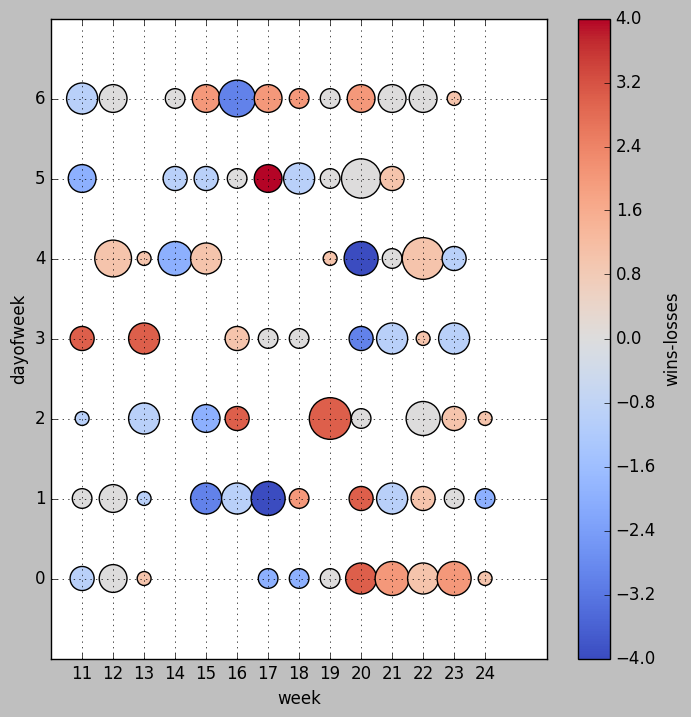

In [47]:
last3 = playerData[(playerData.week >= weekPoints.loc[0]) & 
                   (playerData.week <= weekPoints.loc[1]) & 
                   (playerData.year == 2016)]
last3 = last3[['won', 'week', 'dayofweek']]
print('Total matches from the last 3 mounths to plot: ' + str(len(last3)))

ticks_x = range(weekPoints.loc[0], weekPoints.loc[1]+1)
ticks_y = range(0,7)
mapDF = last3.groupby(['week', 'dayofweek', 'won']).size().unstack('won').fillna(0).copy()
mapDF = mapDF.reset_index()
mapDF['wins-losses'] = mapDF[True] - mapDF[False]
mapDF['total'] = (mapDF[True] + mapDF[False]) #total
sns.reset_orig()
plot = mapDF.plot(kind='scatter', grid=True, x='week', y='dayofweek', c='wins-losses', s=np.asarray(mapDF.total*100),
                  cmap='coolwarm', xticks=ticks_x, yticks=ticks_y, figsize=(8,8))

Number of games per day as heat map:

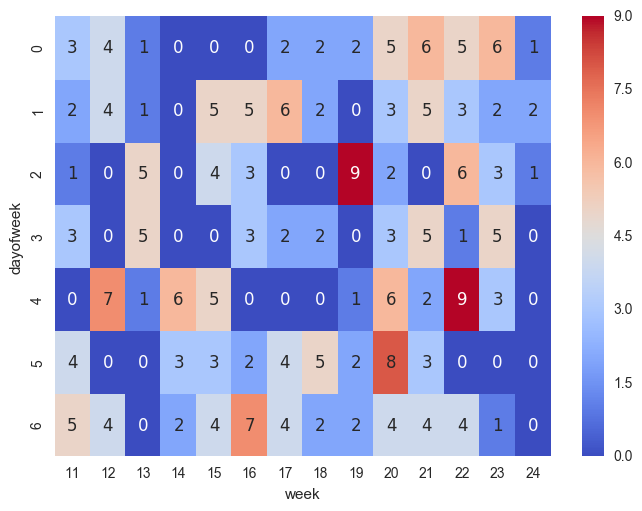

In [49]:
sns.set()
heatMapDF = mapDF.set_index(['week', 'dayofweek'])['total'].unstack('week').fillna(0)
sns.heatmap(heatMapDF, cmap='coolwarm', xticklabels=ticks_x, yticklabels=ticks_y, annot=True)

Win-Loss difference for the days where the player has played at least one game:

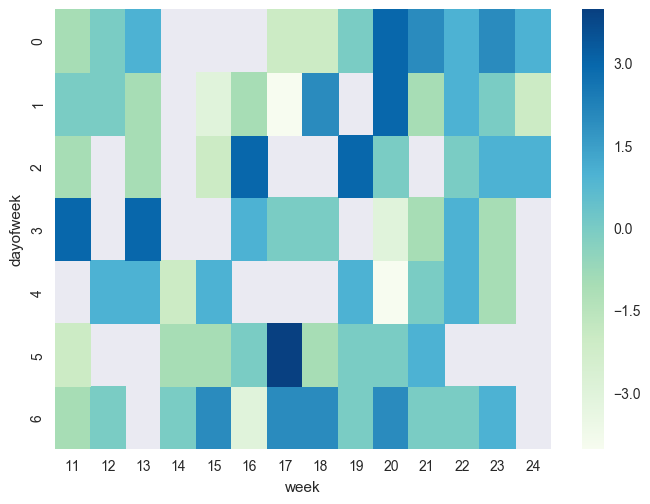

In [50]:
mask = heatMapDF == 0

heatMapDF2 = mapDF.set_index(['week', 'dayofweek'])['wins-losses'].unstack('week').fillna(0)
sns.heatmap(heatMapDF2, xticklabels=ticks_x, cmap='GnBu',yticklabels=ticks_y, mask=mask)

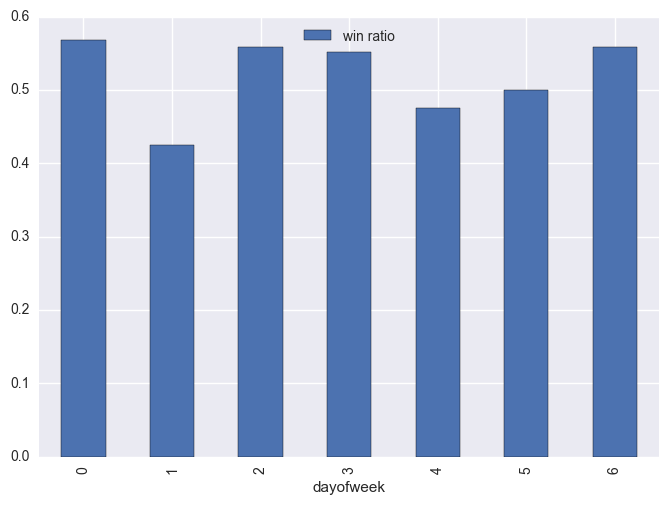

In [51]:
daysWeekDF = mapDF.set_index(['week', 'dayofweek'])
daysWeekDF = daysWeekDF[[True, 'total']]
daysWeekDF = mapDF[['dayofweek', True, 'total']].copy()
daysWeekDF['total wins'] = daysWeekDF[True].astype(int)
daysWeekDF['total'] = daysWeekDF['total'].astype(int)
daysWeekDF = daysWeekDF.drop(True, 1)
daysWeekDF = daysWeekDF.groupby('dayofweek').sum()
daysWeekDF['win ratio'] = daysWeekDF['total wins']/daysWeekDF['total']
daysWeekDF.plot(kind='bar', y='win ratio')

The highest win ratio is on Sunday:

In [52]:
daysWeekDF.sort_values('win ratio').tail(1)

won        total  total wins  win ratio
dayofweek                              
0             37          21   0.567568

## Exercise 3: Performance Clustering

### Generate feature set
We divide time depandant features by duration

In [53]:
df3 = data[['hero_damage','hero_healing', 'tower_damage', 'assists', 'deaths','kills', 'denies','last_hits']]
df3_ = np.asarray(df3)
duration = np.asarray(data['duration']).reshape([data['duration'].shape[0],1])
df3_ = np.divide(df3_, duration)

In [54]:
df4_ = np.asarray(data[['xp_per_min','gold_per_min']])

Combine bot data frames

In [55]:
hero_df = np.concatenate([df3_, df4_], axis=1)
hero_df = np.nan_to_num(hero_df)
hero_names = np.asarray(data['hero_name'])
heros = pd.DataFrame(hero_df)
heros['names'] = data['hero_name']
heros.head()

0         1         2         3         4         5         6  \
0  5.732092  0.000000  0.000000  0.005731  0.004298  0.001910  0.000000   
1  2.404967  0.000000  0.000000  0.003343  0.004776  0.001433  0.001910   
2  5.856256  0.146132  0.106495  0.001433  0.004298  0.003820  0.001910   
3  6.113181  0.000000  0.241165  0.003343  0.004776  0.001910  0.004776   
4  3.012416  0.000000  0.086437  0.002865  0.004776  0.001433  0.001433   

          7      8      9       names  
0  0.018625  367.0  292.0   Ogre Magi  
1  0.005731  242.0  221.0        Riki  
2  0.057784  365.0  371.0   Timbersaw  
3  0.058262  394.0  349.0  Windranger  
4  0.055874  387.0  346.0  Naga Siren

Group by the hero names and pool with mean  

In [56]:
heros_df = heros.groupby('names').mean()
X = np.asarray(heros_df)
names = np.asarray(heros_df.index)
heros_df.head()

0         1         2         3         4  \
names                                                                  
Abaddon             3.528400  0.627549  0.406706  0.005588  0.002560   
Alchemist           4.217645  0.007066  0.762361  0.004312  0.003071   
Ancient Apparition  3.337772  0.080806  0.110601  0.005597  0.003051   
Anti-Mage           3.603822  0.034851  0.971768  0.002920  0.002312   
Arc Warden          4.225727  0.032493  0.686046  0.003665  0.003349   

                           5         6         7           8           9  
names                                                                     
Abaddon             0.002351  0.001586  0.039360  450.769486  383.339138  
Alchemist           0.002333  0.001380  0.088867  529.991266  635.431223  
Ancient Apparition  0.002046  0.001697  0.019287  342.704965  312.405889  
Anti-Mage           0.002978  0.004111  0.107957  560.054722  542.612533  
Arc Warden          0.002008  0.001708  0.053642  426.445013  445.406650

### Perform Clustering
#### K-Means
Find best K with use of silhouette coefficient

In [57]:
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler

# Standardize features by removing the mean and scaling to unit variance
X = StandardScaler().fit_transform(X)



# run 20 epochs to get the best mean silhouette coefficient
epochs = 20
k_max = 20
b_k = np.zeros([epochs, k_max-1])
for epoch in range(20):
    for i in range(2,20):
        lables = KMeans(n_clusters=i).fit_predict(X)
        b_k[epoch,i-1] = metrics.silhouette_score(X, lables)
b = np.mean(b_k, axis=0)
best_k = np.argmax(b) + 1  
print("Best k is: %d" % best_k) 

Best k is: 2


Perform k-means with best k

In [58]:
labels = KMeans(n_clusters=best_k).fit_predict(X)
for i in range(best_k):
    print("### Heros of class %d" % i)
    for h in range(X.shape[0]):
        if labels[h] == i:
            print(names[h])
            
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))   

### Heros of class 0
Abaddon
Ancient Apparition
Axe
Bane
Batrider
Beastmaster
Bounty Hunter
Brewmaster
Centaur Warrunner
Chen
Clockwerk
Crystal Maiden
Dark Seer
Dazzle
Disruptor
Doom
Earth Spirit
Earthshaker
Elder Titan
Enigma
Io
Jakiro
Keeper of the Light
Leshrac
Lich
Lion
Magnus
Mirana
Necrophos
Nyx Assassin
Ogre Magi
Omniknight
Oracle
Phoenix
Puck
Pudge
Pugna
Rubick
Sand King
Shadow Demon
Shadow Shaman
Silencer
Skywrath Mage
Slardar
Spirit Breaker
Techies
Tidehunter
Treant Protector
Tusk
Undying
Vengeful Spirit
Venomancer
Visage
Warlock
Winter Wyvern
Witch Doctor
### Heros of class 1
Alchemist
Anti-Mage
Arc Warden
Bloodseeker
Bristleback
Broodmother
Chaos Knight
Clinkz
Death Prophet
Dragon Knight
Drow Ranger
Ember Spirit
Enchantress
Faceless Void
Gyrocopter
Huskar
Invoker
Juggernaut
Kunkka
Legion Commander
Lifestealer
Lina
Lone Druid
Luna
Lycan
Medusa
Meepo
Morphling
Naga Siren
Nature's Prophet
Night Stalker
Outworld Devourer
Phantom Assassin
Phantom Lancer
Queen of Pain
Razor
Riki


##### Spectral Clustering
Perform Spectral Clustering, it finds the best 'K' by itself.

In [59]:
labels = SpectralClustering().fit_predict(X)

print("Cluster found with Spectral Clustering: %d" % lables.max())

for i in range(int(labels.max())):
    print("### Heros of class %d" % i)
    for h in range(X.shape[0]):
        if labels[h] == i:
            print(names[h])
            
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Cluster found with Spectral Clustering: 18
### Heros of class 0
Bristleback
Chaos Knight
Death Prophet
Gyrocopter
Queen of Pain
Razor
Sniper
Storm Spirit
Tiny
Viper
### Heros of class 1
Abaddon
Alchemist
Anti-Mage
Arc Warden
Axe
Beastmaster
Bloodseeker
Bounty Hunter
Broodmother
Chen
Clinkz
Clockwerk
Dark Seer
Dazzle
Disruptor
Doom
Dragon Knight
Ember Spirit
Enchantress
Enigma
Faceless Void
Huskar
Invoker
Io
Keeper of the Light
Kunkka
Legion Commander
Leshrac
Lich
Lifestealer
Lina
Medusa
Meepo
Mirana
Morphling
Naga Siren
Nature's Prophet
Necrophos
Night Stalker
Nyx Assassin
Omniknight
Oracle
Outworld Devourer
Phoenix
Puck
Pugna
Riki
Shadow Fiend
Shadow Shaman
Silencer
Skywrath Mage
Spectre
Spirit Breaker
Techies
Timbersaw
Tinker
Treant Protector
Undying
Ursa
Venomancer
Visage
Warlock
Weaver
Windranger
Witch Doctor
Wraith King
Zeus
### Heros of class 2
Ancient Apparition
Bane
Crystal Maiden
Earth Spirit
Jakiro
Lion
Ogre Magi
Rubick
Shadow Demon
Vengeful Spirit
Winter Wyvern
### Heros of 

### Evaluation
K-means with silhouette coefficient and Spectral Clustering create clusterings with different cluster sizes. But the silhouette coefficient of k-means is much better, so we recomand k-means with K of 2.